In [ ]:
import os #For interacting with the operating system.
import pandas as pd #Used to handle and manipulate datasets
import numpy as np #For numerical operations
import matplotlib.pyplot as plt #To create visualizations
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler #scales data to a specific range
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM



In [ ]:
store_sales = pd.read_csv('train.csv')
store_sales.head(10) #displays the first 10 rows


,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
5,2013-01-06,1,1,12.0
6,2013-01-07,1,1,10.0
7,2013-01-08,1,1,9.0
8,2013-01-09,1,1,12.0
9,2013-01-10,1,1,9.0


to check if any null values are present

In [ ]:
store_sales.info() #gives info abt the data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227618 entries, 0 to 227617
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    227618 non-null  object 
 1   store   227618 non-null  int64  
 2   item    227618 non-null  int64  
 3   sales   227617 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.9+ MB


In [ ]:
store_sales = store_sales.drop(['store','item'], axis=1) #we find the total sales so dont we need store and item here


In [ ]:
store_sales['date'] = pd.to_datetime(store_sales['date']) #converting date into a month period and them suming the number of sales in a month so that we can predict the next month sales


In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index() #calculating montly sales by group by function


In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp() #converting back to time stamp
monthly_sales.head(10)


,date,sales
0,2013-01-01,114596.0
1,2013-02-01,116257.0
2,2013-03-01,155972.0
3,2013-04-01,172027.0
4,2013-05-01,192094.0
5,2013-06-01,201325.0
6,2013-07-01,215546.0
7,2013-08-01,193231.0
8,2013-09-01,173583.0
9,2013-10-01,166130.0


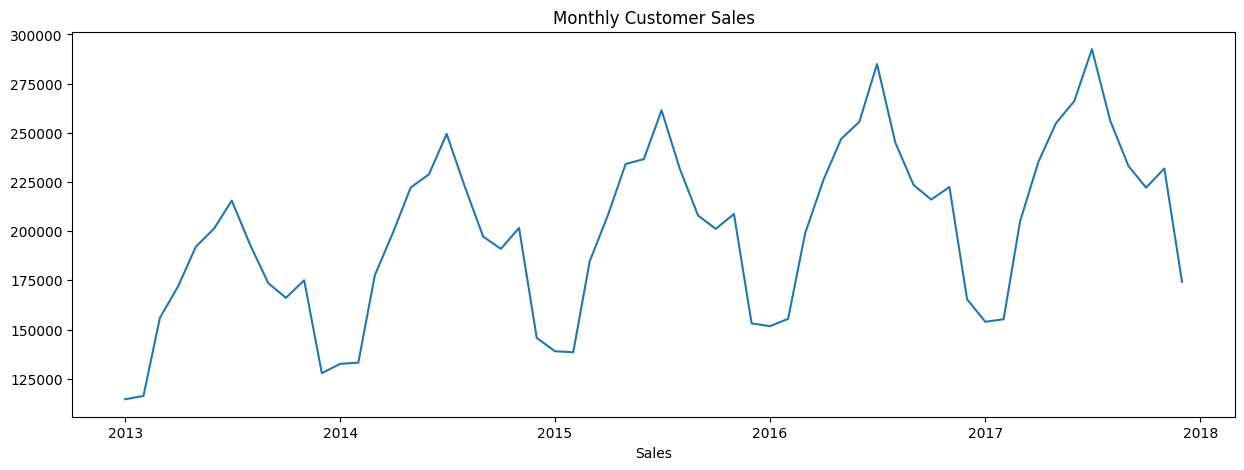

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()


In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)
#here we make the data stationary by finding the differnce of sales monthly

,date,sales,sales_diff
1,2013-02-01,116257.0,1661.0
2,2013-03-01,155972.0,39715.0
3,2013-04-01,172027.0,16055.0
4,2013-05-01,192094.0,20067.0
5,2013-06-01,201325.0,9231.0
6,2013-07-01,215546.0,14221.0
7,2013-08-01,193231.0,-22315.0
8,2013-09-01,173583.0,-19648.0
9,2013-10-01,166130.0,-7453.0
10,2013-11-01,175052.0,8922.0


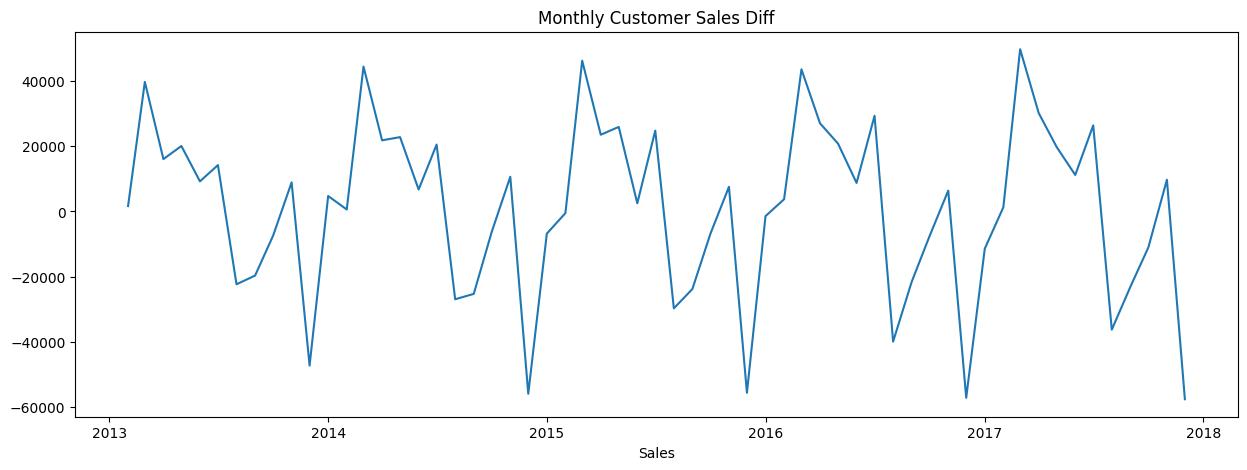

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales Diff")
plt.show()

in this model we use previous 12 months data to prrdict the successive 13th month data

In [ ]:
supverised_data = monthly_sales.drop(['date','sales'], axis=1)


In [ ]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)
supverised_data = supverised_data.dropna().reset_index(drop=True)
supverised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0,16055.0,39715.0,1661.0
1,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0,16055.0,39715.0
2,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0,16055.0
3,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0
4,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0
5,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0
6,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0
7,-25256.0,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0
8,-6263.0,-25256.0,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0
9,10634.0,-6263.0,-25256.0,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0


In [ ]:
train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)


Train Data Shape: (35, 13)
Test Data Shape: (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)


X_train Shape: (35, 12)
y_train Shape: (35,)
X_test Shape: (12, 12)
y_test Shape: (12,)


In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
predict_df


,date
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
5,2017-06-01
6,2017-07-01
7,2017-08-01
8,2017-09-01
9,2017-10-01


In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()

In [ ]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)

In [ ]:
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)


In [ ]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)


In [ ]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)


Linear Regression RMSE:  4388.093318706285
Linear Regression MAE:  3328.454649056536
Linear Regression R2 Score:  0.9889547698786051


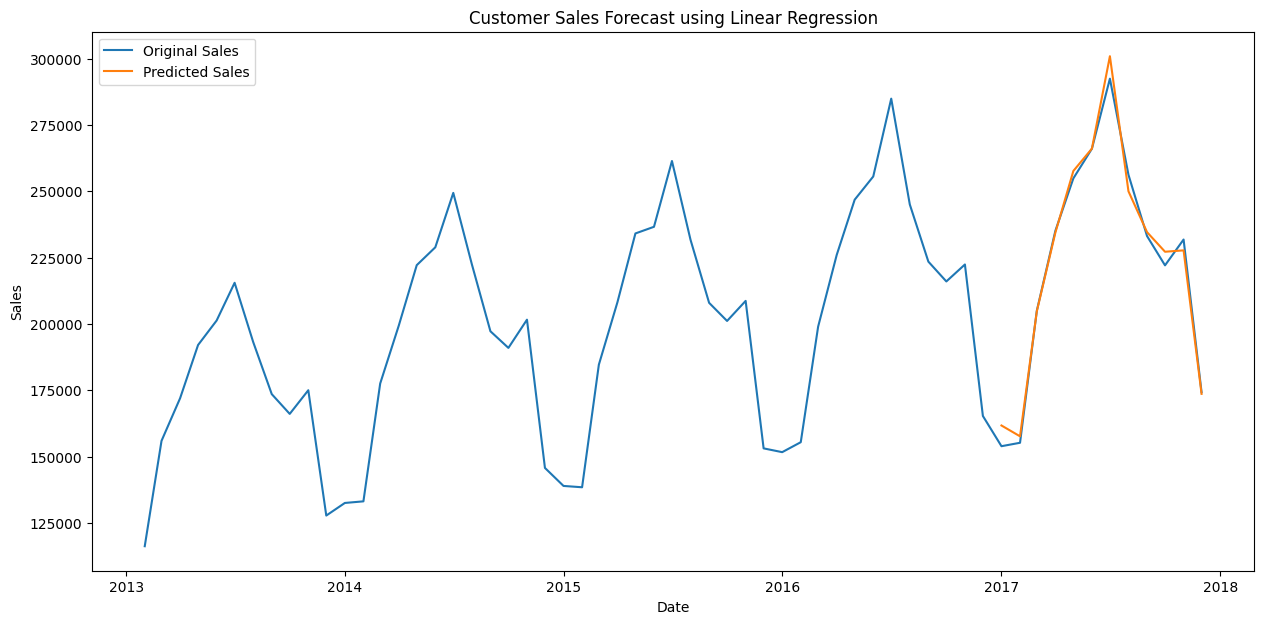

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['linreg_pred'])
plt.title("Customer Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()